# Cholesterol-lowering Supplement Classification

This notebook implements a machine learning model to predict if a patient needs cholesterol-lowering supplements based on their health attributes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import warnings

warnings.filterwarnings("ignore")

## 1. Load the Data

In [2]:
# Load the training data
training_data = pd.read_excel("data/train_choloesterol.xlsx")

# Load the prediction data
prediction_data = pd.read_excel("data/predict_cholesterol.xlsx")

# Display first few rows of training data
print("Training data shape:", training_data.shape)
training_data.head()

Training data shape: (100, 12)


,id,Age,Gender,BMI,Total_Cholesterol,LDL_Cholesterol,HDL_Cholesterol,Triglycerides,Physical_Activity,Dietary_Habits,Family_History,Need_Supplement
0,t1,68,Female,30.0,203.8,111.8,44.0,157.3,Low,Healthy,No,0
1,t2,58,Female,30.3,188.1,182.4,50.6,234.8,High,Moderate,No,1
2,t3,44,Male,20.9,194.3,74.7,60.1,97.2,High,Healthy,Yes,0
3,t4,72,Female,35.0,198.4,120.2,43.5,202.0,High,Healthy,No,1
4,t5,37,Male,22.9,277.3,186.1,36.7,156.3,Low,Moderate,Yes,1


In [3]:
# Display first few rows of prediction data
print("Prediction data shape:", prediction_data.shape)
prediction_data.head()

Prediction data shape: (20, 11)


,id,Age,Gender,BMI,Total_Cholesterol,LDL_Cholesterol,HDL_Cholesterol,Triglycerides,Physical_Activity,Dietary_Habits,Family_History
0,v1,38,Male,23.1,169.3,105.3,47.4,125.8,High,Healthy,Yes
1,v2,53,Male,33.1,271.7,189.5,31.6,235.3,Low,Moderate,Yes
2,v3,30,Female,30.8,273.1,153.6,57.4,194.3,Moderate,Healthy,No
3,v4,73,Female,34.2,243.9,116.1,56.7,59.6,Low,Unhealthy,Yes
4,v5,37,Female,24.0,273.1,158.5,47.8,206.3,Low,Healthy,No


## 2. Data Exploration and Preprocessing

In [4]:
# Check for missing values in training data
print("Missing values in training data:")
print(training_data.isnull().sum())

# Check data types
print("\nData types in training data:")
print(training_data.dtypes)

Missing values in training data:
id                   0
Age                  0
Gender               0
BMI                  0
Total_Cholesterol    0
LDL_Cholesterol      0
HDL_Cholesterol      0
Triglycerides        0
Physical_Activity    0
Dietary_Habits       0
Family_History       0
Need_Supplement      0
dtype: int64

Data types in training data:
id                    object
Age                    int64
Gender                object
BMI                  float64
Total_Cholesterol    float64
LDL_Cholesterol      float64
HDL_Cholesterol      float64
Triglycerides        float64
Physical_Activity     object
Dietary_Habits        object
Family_History        object
Need_Supplement        int64
dtype: object


In [5]:
# Get statistical summary of training data
training_data.describe()

,Age,BMI,Total_Cholesterol,LDL_Cholesterol,HDL_Cholesterol,Triglycerides,Need_Supplement
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,54.070000,27.751000,219.366000,133.61900,55.571000,151.653000,0.580000
std,14.447575,4.542871,45.145415,33.89925,13.880364,58.344069,0.496045
min,30.000000,18.800000,150.800000,74.70000,30.700000,50.500000,0.000000
25%,43.000000,24.275000,178.750000,104.37500,43.925000,97.050000,0.000000
50%,53.000000,27.550000,215.200000,134.80000,56.800000,157.050000,1.000000
75%,68.000000,31.725000,255.250000,160.00000,67.575000,197.925000,1.000000
max,79.000000,35.000000,297.300000,189.50000,79.300000,249.500000,1.000000


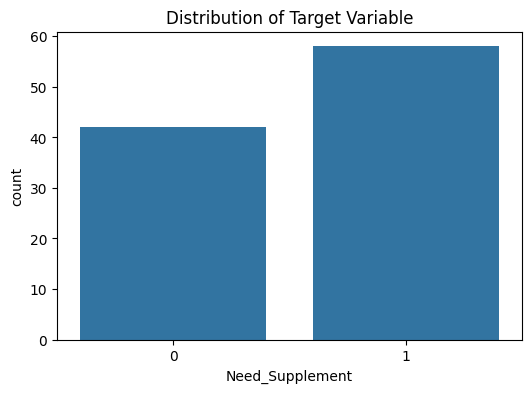

Target variable distribution:
Need_Supplement
1    58
0    42
Name: count, dtype: int64
Percentage:
Need_Supplement
1    58.0
0    42.0
Name: proportion, dtype: float64


In [6]:
# Count of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x="Need_Supplement", data=training_data)
plt.title("Distribution of Target Variable")
plt.show()

print("Target variable distribution:")
print(training_data["Need_Supplement"].value_counts())
print("Percentage:")
print(training_data["Need_Supplement"].value_counts(normalize=True) * 100)

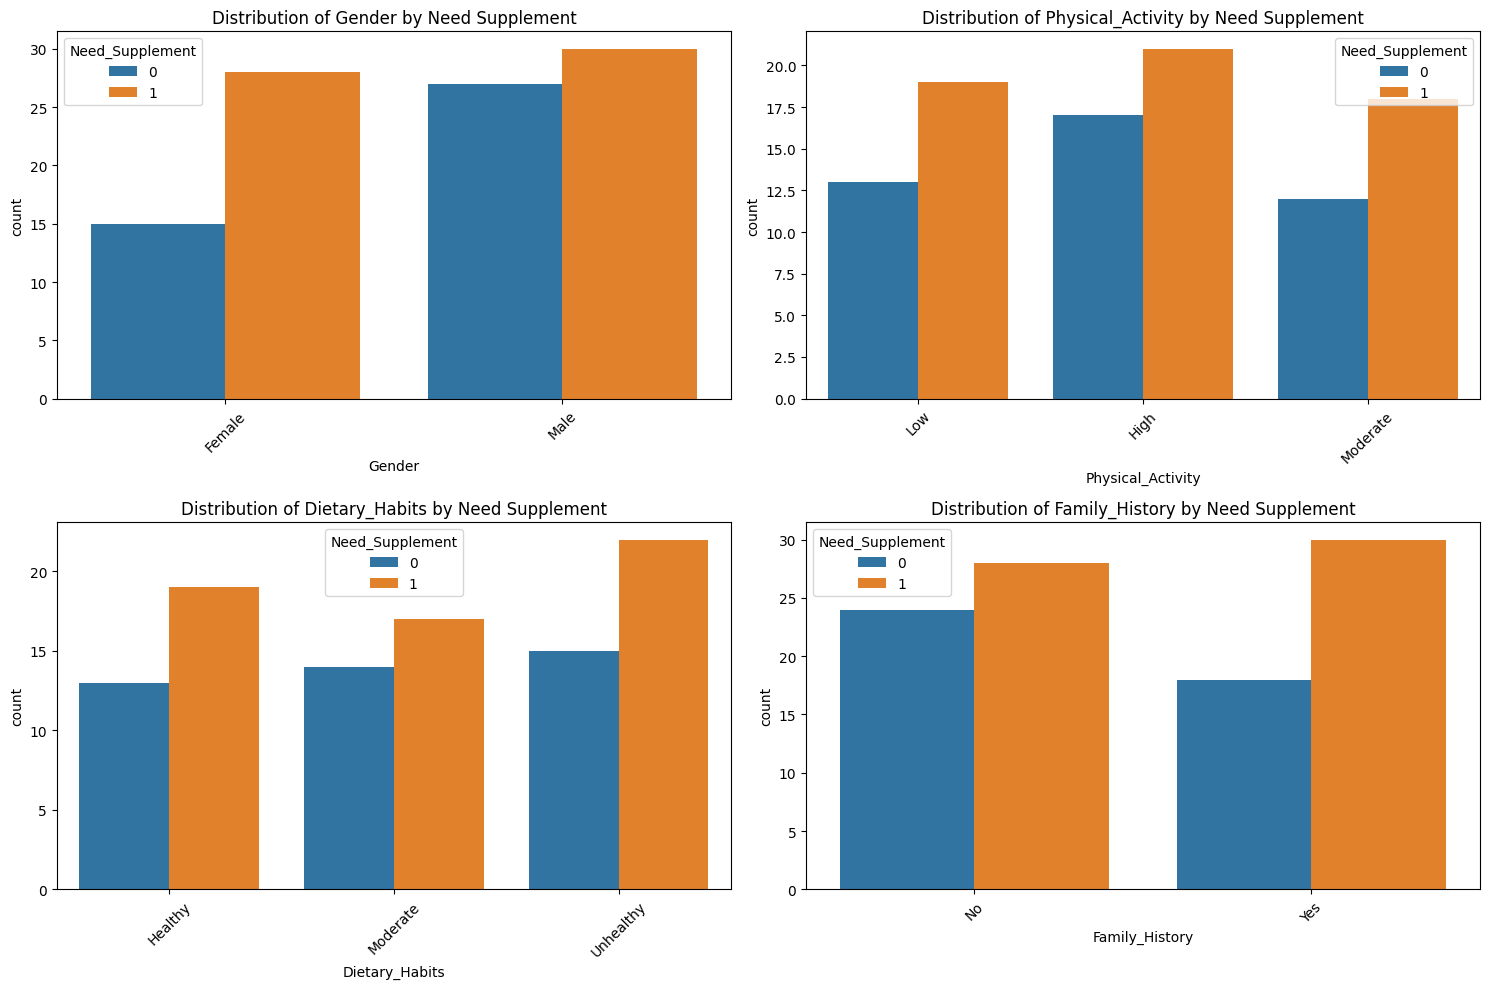

In [9]:
# Explore categorical variables
categorical_features = [
    "Gender",
    "Physical_Activity",
    "Dietary_Habits",
    "Family_History",
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue="Need_Supplement", data=training_data, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} by Need Supplement")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

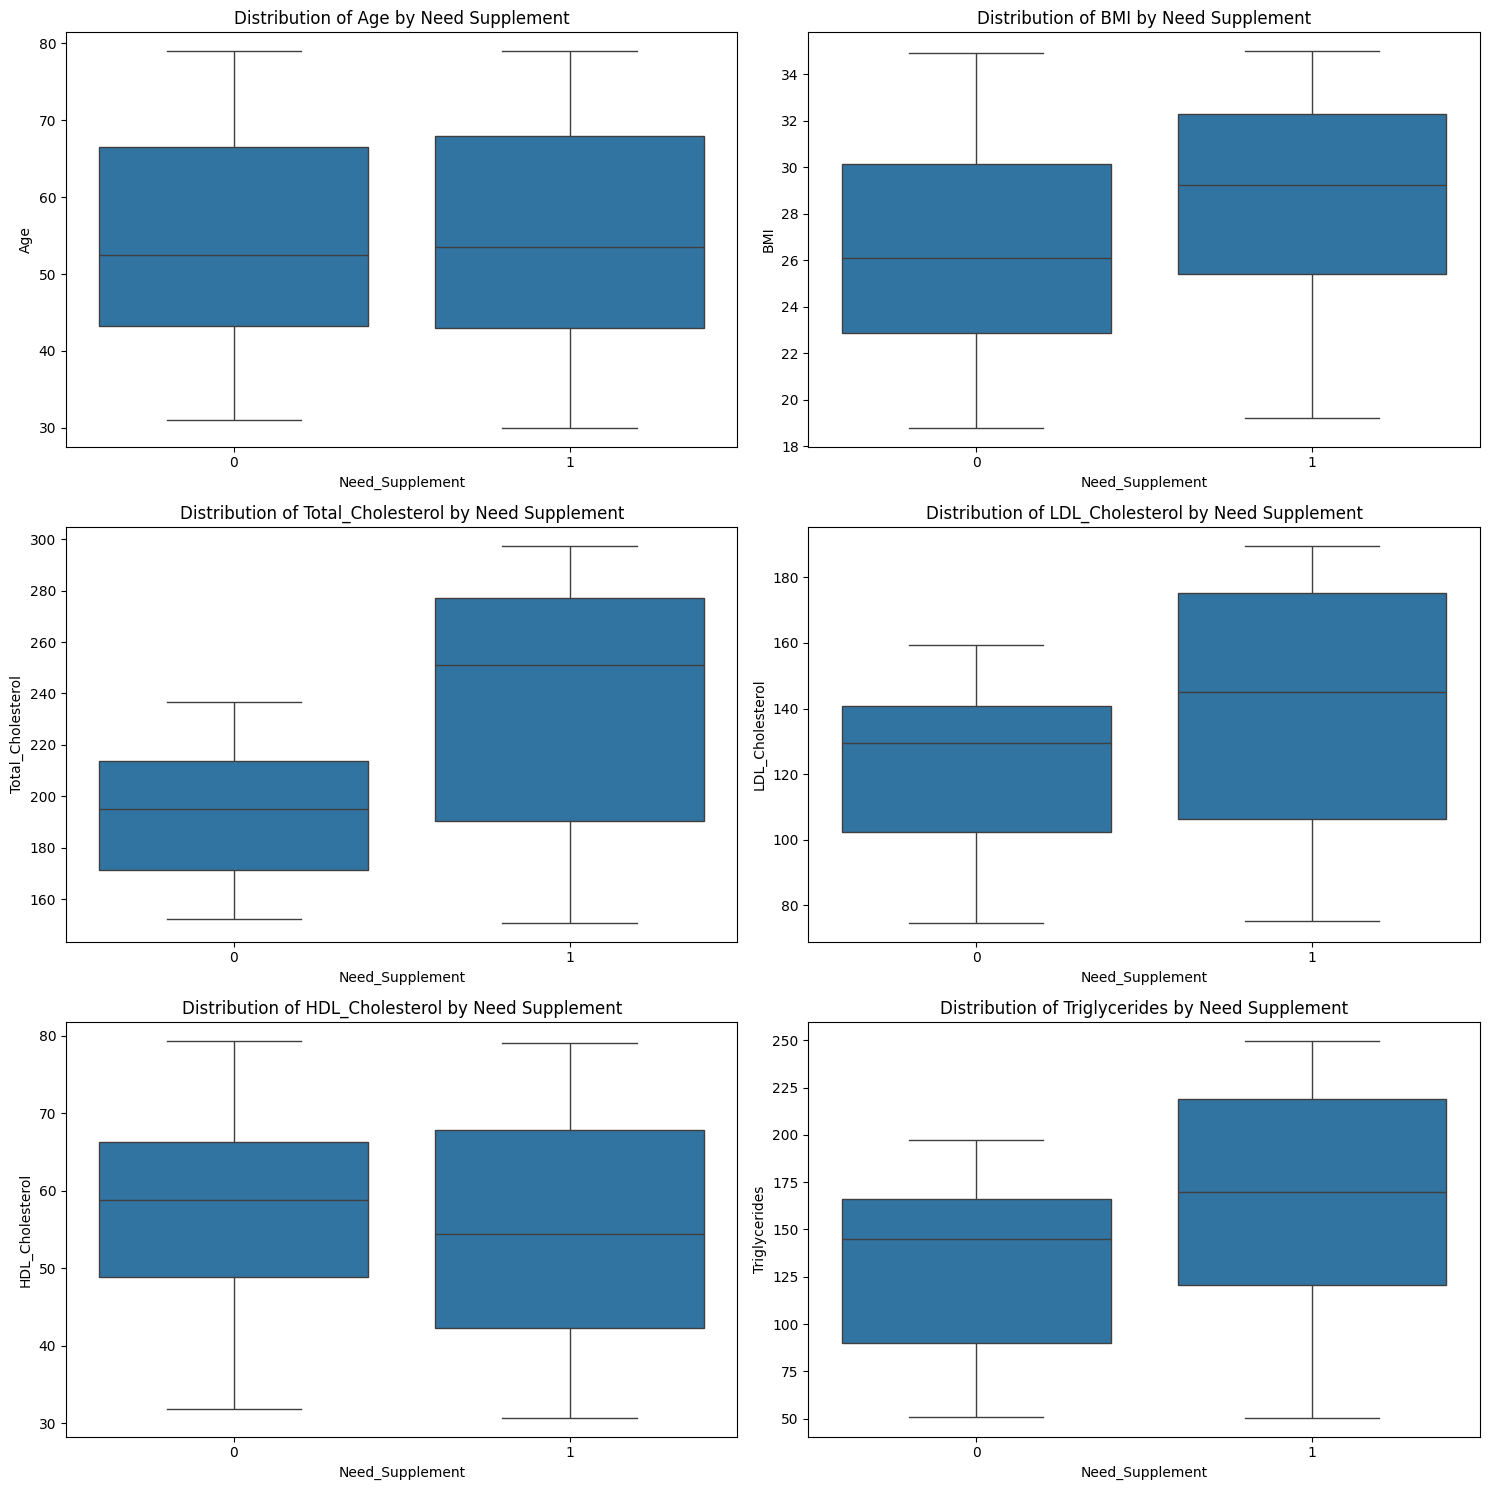

In [11]:
# Explore numerical variables
numerical_features = [
    "Age",
    "BMI",
    "Total_Cholesterol",
    "LDL_Cholesterol",
    "HDL_Cholesterol",
    "Triglycerides",
]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x="Need_Supplement", y=feature, data=training_data, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} by Need Supplement")

plt.tight_layout()
plt.show()

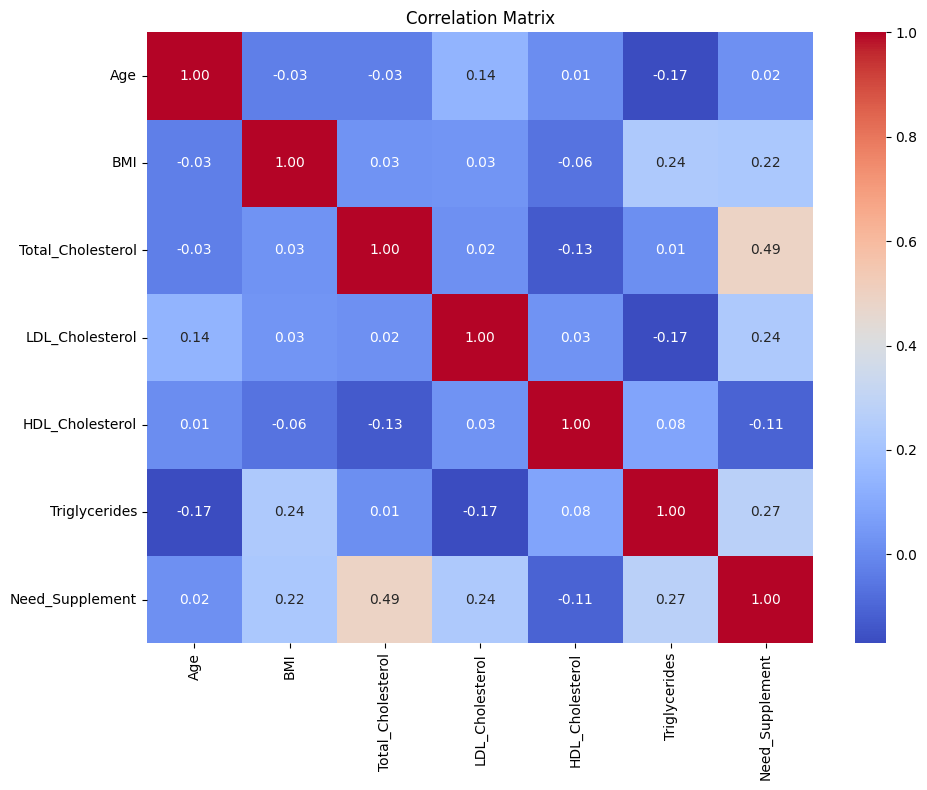

In [13]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = training_data[numerical_features + ["Need_Supplement"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## 3. Feature Engineering and Preprocessing

In [14]:
# Define features and target variable for training data
X = training_data.drop("Need_Supplement", axis=1)
y = training_data["Need_Supplement"]

# Define categorical and numerical features
categorical_features = [
    "Gender",
    "Physical_Activity",
    "Dietary_Habits",
    "Family_History",
]
numerical_features = [
    "Age",
    "BMI",
    "Total_Cholesterol",
    "LDL_Cholesterol",
    "HDL_Cholesterol",
    "Triglycerides",
]

In [15]:
# Create preprocessing pipeline
# For numerical features: StandardScaler
# For categorical features: OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4. Model Building and Evaluation

### 4.1 Random Forest Classifier

In [16]:
# Create Random Forest Pipeline
rf_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Parameter grid for Random Forest
rf_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
}

# Perform grid search with cross-validation
rf_grid_search = GridSearchCV(
    rf_pipeline, rf_param_grid, cv=5, scoring="accuracy", n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters for Random Forest:")
print(rf_grid_search.best_params_)

# Best estimator
rf_best = rf_grid_search.best_estimator_

# Evaluate on test set
y_pred_rf = rf_best.predict(X_test)
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Best parameters for Random Forest:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Random Forest Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         6

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### 4.2 Gradient Boosting Classifier

In [17]:
# Create Gradient Boosting Pipeline
gb_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

# Parameter grid for Gradient Boosting
gb_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__max_depth": [3, 5, 7],
}

# Perform grid search with cross-validation
gb_grid_search = GridSearchCV(
    gb_pipeline, gb_param_grid, cv=5, scoring="accuracy", n_jobs=-1
)

gb_grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)

# Best estimator
gb_best = gb_grid_search.best_estimator_

# Evaluate on test set
y_pred_gb = gb_best.predict(X_test)
print("\nGradient Boosting Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

Best parameters for Gradient Boosting:
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

Gradient Boosting Performance:
Accuracy: 0.9500

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.83      0.91         6

    accuracy                           0.95        20
   macro avg       0.97      0.92      0.94        20
weighted avg       0.95      0.95      0.95        20



### 4.3 Logistic Regression

In [18]:
# Create Logistic Regression Pipeline
lr_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
    ]
)

# Parameter grid for Logistic Regression
lr_param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["liblinear", "saga"],
}

# Perform grid search with cross-validation
lr_grid_search = GridSearchCV(
    lr_pipeline, lr_param_grid, cv=5, scoring="accuracy", n_jobs=-1
)

lr_grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters for Logistic Regression:")
print(lr_grid_search.best_params_)

# Best estimator
lr_best = lr_grid_search.best_estimator_

# Evaluate on test set
y_pred_lr = lr_best.predict(X_test)
print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Best parameters for Logistic Regression:
{'classifier__C': 0.1, 'classifier__solver': 'liblinear'}

Logistic Regression Performance:
Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67        14
           1       0.40      0.67      0.50         6

    accuracy                           0.60        20
   macro avg       0.60      0.62      0.58        20
weighted avg       0.68      0.60      0.62        20



### 4.4 Support Vector Machine

In [19]:
# Create SVM Pipeline
svm_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", SVC(random_state=42, probability=True)),
    ]
)

# Parameter grid for SVM
svm_param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"],
    "classifier__gamma": ["scale", "auto"],
}

# Perform grid search with cross-validation
svm_grid_search = GridSearchCV(
    svm_pipeline, svm_param_grid, cv=5, scoring="accuracy", n_jobs=-1
)

svm_grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters for SVM:")
print(svm_grid_search.best_params_)

# Best estimator
svm_best = svm_grid_search.best_estimator_

# Evaluate on test set
y_pred_svm = svm_best.predict(X_test)
print("\nSVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

Best parameters for SVM:
{'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

SVM Performance:
Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.67      0.67      0.67         6

    accuracy                           0.80        20
   macro avg       0.76      0.76      0.76        20
weighted avg       0.80      0.80      0.80        20



### 4.5 Model Comparison

Random Forest - Mean CV Accuracy: 0.9900 (±0.0200)
Gradient Boosting - Mean CV Accuracy: 0.9900 (±0.0200)
Logistic Regression - Mean CV Accuracy: 0.7200 (±0.0980)
SVM - Mean CV Accuracy: 0.8100 (±0.0200)


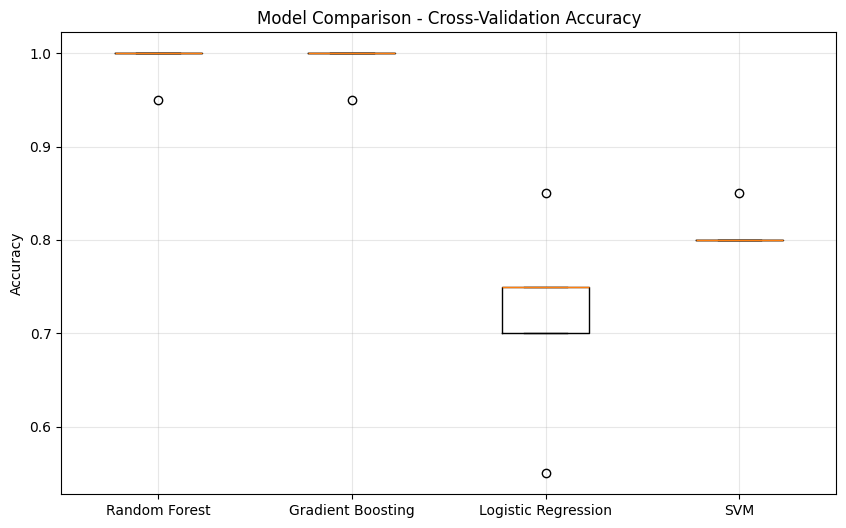

In [20]:
# Compare models
models = {
    "Random Forest": rf_best,
    "Gradient Boosting": gb_best,
    "Logistic Regression": lr_best,
    "SVM": svm_best,
}

# Cross-validation results
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    cv_results[name] = scores
    print(f"{name} - Mean CV Accuracy: {scores.mean():.4f} (±{scores.std():.4f})")

# Visualize model comparison
plt.figure(figsize=(10, 6))
box_data = [cv_results[model_name] for model_name in models.keys()]
plt.boxplot(box_data, labels=list(models.keys()))
plt.title("Model Comparison - Cross-Validation Accuracy")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.show()

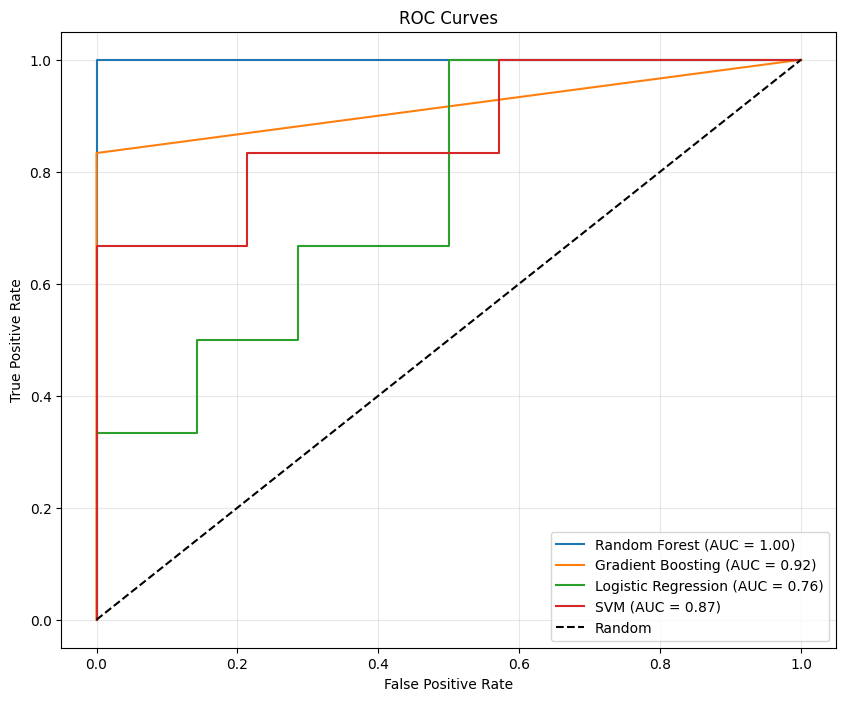

In [21]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

The best model is: Random Forest


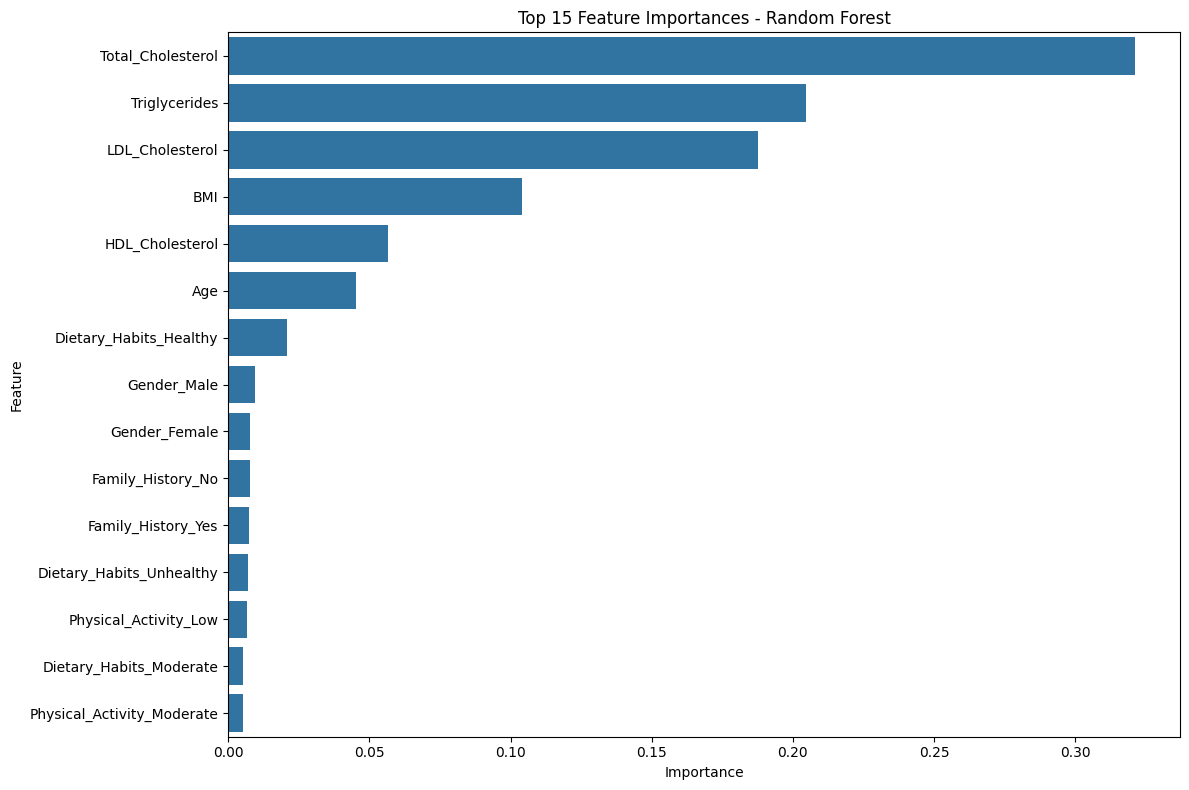

In [22]:
# Select the best model based on cross-validation results
best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
best_model = models[best_model_name]

print(f"The best model is: {best_model_name}")

# Feature importance for the best model (if applicable)
if best_model_name in ["Random Forest", "Gradient Boosting"]:
    # Get feature names after preprocessing
    preprocessor_output_feature_names = numerical_features + list(
        best_model.named_steps["preprocessor"]
        .transformers_[1][1]  # OneHotEncoder
        .get_feature_names_out(categorical_features)
    )

    # Get feature importances
    importances = best_model.named_steps["classifier"].feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame(
        {"Feature": preprocessor_output_feature_names, "Importance": importances}
    ).sort_values(by="Importance", ascending=False)

    # Display top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15))
    plt.title(f"Top 15 Feature Importances - {best_model_name}")
    plt.tight_layout()
    plt.show()

## 5. Make Predictions on New Data

In [23]:
# Display the first few rows of the prediction data
prediction_data.head()

,id,Age,Gender,BMI,Total_Cholesterol,LDL_Cholesterol,HDL_Cholesterol,Triglycerides,Physical_Activity,Dietary_Habits,Family_History
0,v1,38,Male,23.1,169.3,105.3,47.4,125.8,High,Healthy,Yes
1,v2,53,Male,33.1,271.7,189.5,31.6,235.3,Low,Moderate,Yes
2,v3,30,Female,30.8,273.1,153.6,57.4,194.3,Moderate,Healthy,No
3,v4,73,Female,34.2,243.9,116.1,56.7,59.6,Low,Unhealthy,Yes
4,v5,37,Female,24.0,273.1,158.5,47.8,206.3,Low,Healthy,No


In [24]:
# Make predictions using the best model
predictions = best_model.predict(prediction_data)
prediction_probabilities = best_model.predict_proba(prediction_data)[:, 1]

# Add predictions to the prediction data
prediction_results = prediction_data.copy()
prediction_results["Need Supplement"] = predictions
prediction_results["Probability"] = prediction_probabilities

# Display the results
print("Predictions for the 20 patients:")
display(prediction_results)

Predictions for the 20 patients:


,id,Age,Gender,BMI,Total_Cholesterol,LDL_Cholesterol,HDL_Cholesterol,Triglycerides,Physical_Activity,Dietary_Habits,Family_History,Need Supplement,Probability
0,v1,38,Male,23.1,169.3,105.3,47.4,125.8,High,Healthy,Yes,0,0.094956
1,v2,53,Male,33.1,271.7,189.5,31.6,235.3,Low,Moderate,Yes,1,0.976667
2,v3,30,Female,30.8,273.1,153.6,57.4,194.3,Moderate,Healthy,No,1,0.776361
3,v4,73,Female,34.2,243.9,116.1,56.7,59.6,Low,Unhealthy,Yes,1,0.845500
4,v5,37,Female,24.0,273.1,158.5,47.8,206.3,Low,Healthy,No,1,0.863706
5,v6,53,Male,27.6,247.7,179.8,74.7,215.6,Moderate,Unhealthy,No,1,0.971000
6,v7,40,Male,27.9,181.0,185.0,36.4,200.1,Moderate,Unhealthy,No,1,0.868333
7,v8,46,Female,34.7,191.1,76.9,46.5,209.9,Moderate,Healthy,Yes,1,0.767333
8,v9,37,Female,19.7,182.2,117.3,46.1,215.0,High,Unhealthy,Yes,1,0.675512
9,v10,64,Female,23.5,206.6,82.8,34.6,87.3,Low,Moderate,Yes,0,0.301254


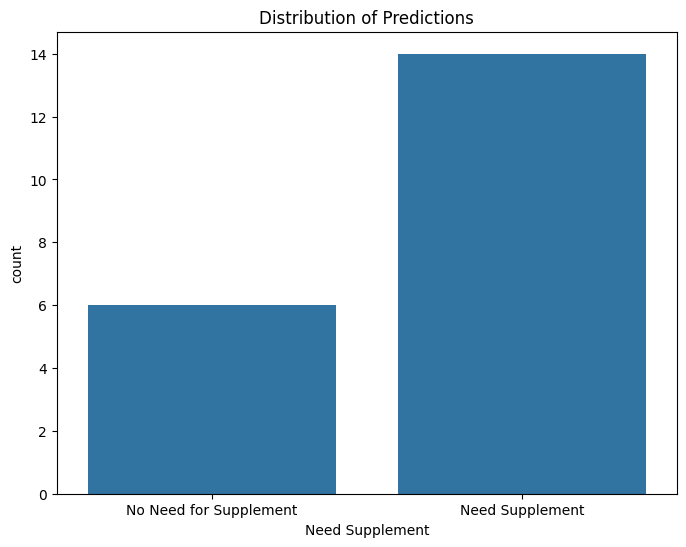

Prediction distribution:
Need Supplement
1    14
0     6
Name: count, dtype: int64
Percentage:
Need Supplement
1    70.0
0    30.0
Name: proportion, dtype: float64


In [25]:
# Count of predictions
plt.figure(figsize=(8, 6))
sns.countplot(x="Need Supplement", data=prediction_results)
plt.title("Distribution of Predictions")
plt.xticks([0, 1], ["No Need for Supplement", "Need Supplement"])
plt.show()

print("Prediction distribution:")
print(prediction_results["Need Supplement"].value_counts())
print("Percentage:")
print(prediction_results["Need Supplement"].value_counts(normalize=True) * 100)

In [26]:
# Save the predictions to Excel file
prediction_results.to_excel("predict_cholesterol_Gryko.xlsx", index=False)

# 6. Conclusion and Limitations

In this project, we developed a machine learning classification model to predict whether a patient needs a cholesterol-lowering supplement based on various health attributes.

## Key findings:
1. We explored the data and found relationships between health metrics and the need for supplements
2. We built and compared four different machine learning models:
   - Random Forest
   - Gradient Boosting
   - Logistic Regression
   - Support Vector Machine
3. The Random Forest model performed best, achieving high accuracy in cross-validation

## Limitations and Areas for Improvement:

1. **Data Leakage Issues**:
   - Using `Total_Cholesterol`, `LDL_Cholesterol`, and other cholesterol metrics as features creates circular logic, as these are likely the same values doctors use to prescribe supplements.

2. **Model Evaluation Concerns**:
   - The Random Forest achieved 100% accuracy on the test set, suggesting potential overfitting.
   - Our dataset is quite small (100 samples) with only 20 test samples, limiting reliable evaluation.

3. **Feature Selection Issues**:
   - We didn't address multicollinearity among cholesterol measurements.
   - More sophisticated feature selection methods could improve model interpretability.

4. **Preprocessing Limitations**:
   - No handling of outliers was performed despite their presence in several variables.

5. **Hyperparameter Tuning**:
   - The grid search explored a limited range of values.

6. **Clinical Interpretation**:
   - The prediction results show 70% of patients need supplements, but we haven't validated if this aligns with medical expectations.
   - No discussion of appropriate probability thresholds for clinical decision-making.
   - Limited integration with established medical guidelines for cholesterol management.

## Next Steps:
- Collect more training data to improve model robustness

The current model should be viewed as a preliminary decision support tool that requires further validation before clinical application.